# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [3]:
# Notebook utils
from nb_utils import (get_test_data_loader, load_config, load_summaries,
                      load_model, apply_model, compute_metrics,
                      plot_train_history, draw_sample, plot_metrics)

In [4]:
%matplotlib inline

In [5]:
# Config path
config_file = '../configs/mpnn.yaml'

In [6]:
!cat $config_file

output_dir: ${SCRATCH}/heptrkx/results/mpnn_001

trainer:
    name: gnn_sparse

data:
    name: hitgraphs_sparse
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_high_000
    n_train: 49152
    n_valid: 4096
    real_weight: 5 #6.25  # 0.5 / 0.08
    batch_size: 4
    n_workers: 4

model:
    name: mpnn
    input_dim: 3
    hidden_node_dim: 64
    hidden_edge_dim: 64
    n_graph_iters: 8
    layer_norm: true
    loss_func: binary_cross_entropy_with_logits

optimizer:
    name: Adam
    learning_rate: 0.001
    lr_scaling: sqrt
    lr_warmup_epochs: 5
    lr_decay_schedule:
        - {start_epoch: 16, end_epoch: 32, factor: 0.1}
        - {start_epoch: 32, end_epoch: 64, factor: 0.01}

training:
    n_epochs: 64


In [7]:
config = load_config(config_file)
summaries = load_summaries(config)

/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks/nb_utils.py:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


In [8]:
config

{'output_dir': '${SCRATCH}/heptrkx/results/mpnn_001',
 'trainer': {'name': 'gnn_sparse'},
 'data': {'name': 'hitgraphs_sparse',
  'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_000',
  'n_train': 49152,
  'n_valid': 4096,
  'real_weight': 5,
  'batch_size': 4,
  'n_workers': 4},
 'model': {'name': 'mpnn',
  'input_dim': 3,
  'hidden_node_dim': 64,
  'hidden_edge_dim': 64,
  'n_graph_iters': 8,
  'layer_norm': True,
  'loss_func': 'binary_cross_entropy_with_logits'},
 'optimizer': {'name': 'Adam',
  'learning_rate': 0.001,
  'lr_scaling': 'sqrt',
  'lr_warmup_epochs': 5,
  'lr_decay_schedule': [{'start_epoch': 16, 'end_epoch': 32, 'factor': 0.1},
   {'start_epoch': 32, 'end_epoch': 64, 'factor': 0.01}]},
 'training': {'n_epochs': 64}}

In [9]:
summaries

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.298061,0,2519.074478,0.206325,0.900549,104.738376
1,0.00100,0.155043,1,2517.704575,0.131519,0.946746,104.878865
2,0.00100,0.125819,2,2516.073753,0.112970,0.956756,104.755186
3,0.00100,0.115648,3,2538.351788,0.114282,0.955689,104.750780
4,0.00100,0.108011,4,2516.993619,0.099701,0.962151,104.630954
5,0.00100,0.108165,5,2518.864391,0.087816,0.967561,104.732117
6,0.00100,0.100372,6,2516.186230,0.092755,0.964371,104.805753
7,0.00100,0.098929,7,2516.087735,0.094929,0.967071,104.603716
8,0.00100,0.098191,8,2539.625267,0.088646,0.967558,104.751989
9,0.00100,0.092833,9,2515.401356,0.091844,0.965453,104.793864


## Plot the Training loss and accuracy

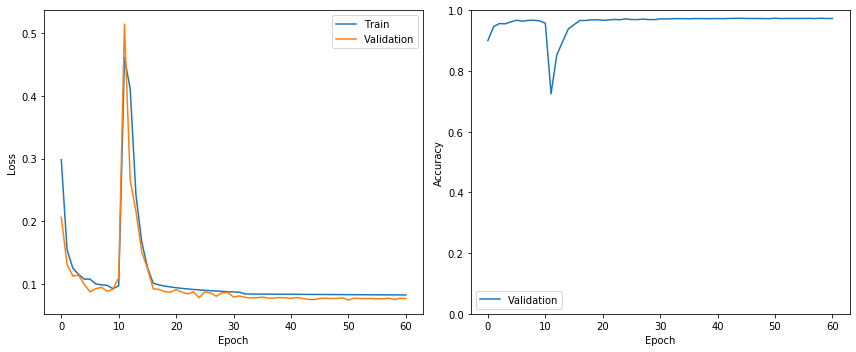

In [10]:
plot_train_history(summaries)

## Load the trained model

In [11]:
# Find the best epoch
best_summary = summaries.loc[[summaries.valid_loss.idxmin()]]
best_summary

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
50,0.00001,0.083333,50,2519.520472,0.074798,0.97429,104.663845


In [12]:
# Load model from best epoch
model = load_model(config, reload_epoch=best_summary.epoch).eval()

print(model)
print('Parameters: %i' % sum(p.numel() for p in model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=134, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=131, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): ReLU

## Load the test data set

In [13]:
import torch
from torch.utils.data import Subset, DataLoader

from torch_geometric.data import Batch

from datasets.hitgraphs_sparse import HitGraphDataset

from nb_utils import get_input_dir

def get_dataset(config):
    return HitGraphDataset(get_input_dir(config))

def get_test_data_loader(config, n_test=16):
    # Take the test set from the back
    full_dataset = get_dataset(config)
    test_indices = len(full_dataset) - 1 - torch.arange(n_test)
    test_dataset = Subset(full_dataset, test_indices)
    return DataLoader(test_dataset, batch_size=1, collate_fn=Batch.from_data_list)

In [14]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

## Evaluate the model on the test dataset

In [15]:
import torch

@torch.no_grad()
def apply_model(model, data_loader):
    preds, targets = [], []
    for batch in data_loader:
        preds.append(torch.sigmoid(model(batch)).squeeze(0))
        targets.append(batch.y.squeeze(0))
    return preds, targets

In [16]:
%%time
test_preds, test_targets = apply_model(model, test_loader)

CPU times: user 5min 59s, sys: 2.71 s, total: 6min 2s
Wall time: 1min 30s


In [17]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9741
Precision: 0.7546
Recall:    0.9487


In [18]:
threshold = 0.6
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.6
Accuracy:  0.9782
Precision: 0.7947
Recall:    0.9394


In [19]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.7
Accuracy:  0.9813
Precision: 0.8320
Recall:    0.9275


In [20]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9838
Precision: 0.8727
Recall:    0.9070


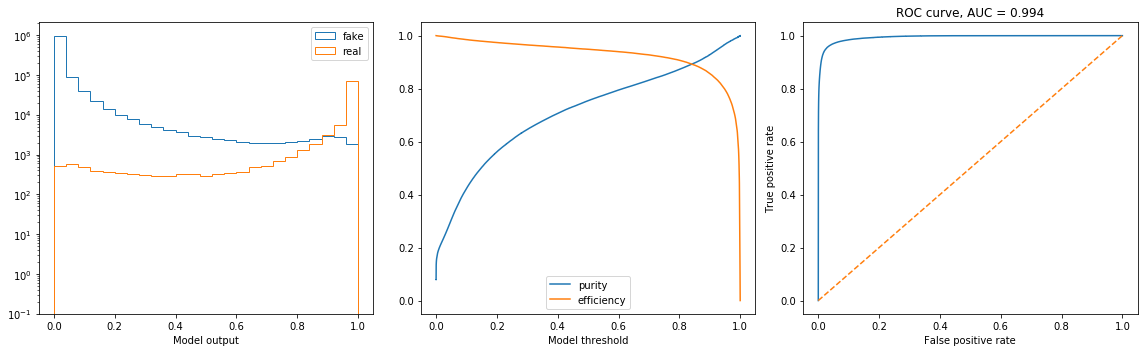

In [21]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions